In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
import pymc as pm

def load_data(n_years=None):
    df = pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                       sheet_name="Raw Data", header=None, 
                       engine="openpyxl")
    
    df_data = df.iloc[10:6124,2:4]
    df_data.columns = ["Age", "d18o"]
    
    # set first year to 0 and choose years less than "n_years"
    df_data["Age"] -= min(df_data["Age"])
    if n_years is not None:
        df_data = df_data[df_data["Age"] <= n_years]
    
    # center data
    df_data["d18o"] -= np.mean(df_data["d18o"]) 
    
    t = df_data["Age"].values.astype("float")
    y = df_data["d18o"].values.astype("float")

    return t, y

In [2]:
def interactive_fit(t, y, Pmin=400, Pmax=30000, n_freqs=50000, 
                   n_samples=2000, n_tune=1000, n_chains=4, target_accept=0.95):
    # --- Initialize storage --- 
    residuals = y.copy()
    harmonics = []
    all_fits = []   
    # --- First while loop: main iteration --- 
    while True:
        plt.close('all')
    # --- 1. Compute periodogram of residuals --- 
        f, I, peaks = l_s_periodogram(t, residuals, Pmin=Pmin, Pmax=Pmax, n_freqs=n_freqs)
        candidate_periods = 1/f[peaks]
        candidate_powers = I[peaks]
    # --- 2. Plot periodogram with peaks --- 
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    # --- Periodogram plot --- 
        ax1.plot(1/f, I, 'k-', lw=0.5)
        ax1.plot(candidate_periods, candidate_powers, 'ro', ms=5)
        ax1.set_xscale('log')
        ax1.set_xlabel('Period')
        ax1.set_ylabel('Power')
        ax1.set_title('Periodogram of Residuals')
    # --- Current residuals --- 
        ax2.plot(t, residuals, 'b.', alpha=0.3, label='Residuals')
        ax2.legend()
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Measurement')
        ax2.set_title('Current Residuals')
        plt.tight_layout()
        plt.show() 
    # --- 3. Ask user for period selection (sorted by power, top 10) --- 
        print("\n------------------------------------")
        print("\nPossible Peaks sorted by power:")
        sorted_indices = np.argsort(candidate_powers)[::-1][:10]  # Top 10 indices
        for i, idx in enumerate(sorted_indices): print(f"{i}: {candidate_periods[idx]:.2f} (power: {candidate_powers[idx]:.2f})")
        print("\n------------------------------------")
        print(f"\nN inferred harmonics: {len(all_fits)}")
        if all_fits:
            print("Of periods:")
            for i, fit in enumerate(all_fits, 1): print(f"  {i}: {fit['period']:.0f}")
        print("\n------------------------------------")
        user_input = input("\nSelect (0-9)  Use '-1' to finish: ").strip()
    # --- Exit condition --- 
        if user_input == "-1":
            print("Finished fitting.")
            break
        try:
            selected_i = int(user_input)               # Convert input to integer index (now mapped to sorted list)
            if selected_i < 0 or selected_i >= len(sorted_indices): raise ValueError
            selected_idx = sorted_indices[selected_i]  # Map back to original index
            selected_period = candidate_periods[selected_idx]
            selected_power = candidate_powers[selected_idx]
        except ValueError:
            print(f"Invalid input. Please enter 0-{len(sorted_indices)-1} or '-1'")
            continue
        
        print(f"\nSelected period: {selected_period:.2f} (power: {selected_power:.2f})")
    # --- Second while loop: fit checking --- 
        while True:
    # --- Fit harmonic model --- 
            (A_hat, s_A_hat, P_hat, s_P_hat, phi_hat, s_phi_hat), trace = fit_harmonic(
                                                                                       t, residuals,
                                                                                       period_guess=selected_period,
                                                                                       n_samples=n_samples,
                                                                                       n_tune=n_tune,
                                                                                       n_chains=n_chains,
                                                                                       target_accept=target_accept
                                                                                      )
    # --- Generate the fitted harmonic --- 
            harmonic = A_hat * np.cos(2*np.pi/P_hat * t + phi_hat)
            
    # --- Plotting --- 
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    # --- First plot: original data + current model --- 
            ax1.plot(t, y, 'k.', alpha=0.3, label='Original data')
            ax1.plot(t, sum(harmonics) + harmonic, 'g-', lw=1.5, label='Total model')
            ax1.set_xlabel('Time')
            ax1.set_ylabel('Measurement')
            ax1.set_title(f'Current Model Fit')
            ax1.legend()
    # --- Second plot: Residuals + current harmonic --- 
            ax2.plot(t, residuals, 'b.', alpha=0.5, label='Current residuals')
            ax2.plot(t, harmonic, 'r-', lw=2, label='New harmonic fit')
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Residuals')
            ax2.set_title(f'New Harmonic Component (P = {P_hat:.2f}, A = {A_hat:.2f} φ = {phi_hat:.2f})')
            ax2.legend()
            plt.tight_layout()
            plt.show()
            
    # --- Control/Confirm/exit --- 
            print("\n------------------------------------")
            confirm = input("Keep this fit? (y/n/r: refit with new period): ").strip().lower()
            print("\n------------------------------------")
            if confirm == 'y':
        # --- Accept the fit --- 
                harmonics.append(harmonic)
                residuals -= harmonic
                all_fits.append({
                                 'period': P_hat,
                                 's_period': s_P_hat,
                                 'amplitude': A_hat,
                                 's_amplitude': s_A_hat,
                                 'phi': phi_hat,
                                 's_phi': s_phi_hat,
                                 'harmonic': harmonic
                                })                
                print(f"Added harmonic with P = {P_hat:.2f} A = {A_hat:.2f} phi = {phi_hat:.2f}")
                break                
            elif confirm == 'n':
        # --- Reject the fit - will return to period selection --- 
                print("Discarding this fit")
                break            
            elif confirm == 'r':
        # --- Retry the sampling with this period value --- 
                print("Resampling same period")
                continue                
            else:
                print("Invalid input. Please enter 'y', 'n', or 'r'")
                continue
    param = pd.DataFrame([{'period': f['period'],'s_period': f['s_period'],'amplitude': f['amplitude'],
                           's_amplitude': f['s_amplitude'],'phi': f['phi'],'s_phi': f['s_phi']} for f in all_fits])
    return {'residuals': residuals,'param': param,'final_model': sum(harmonics) if harmonics else np.zeros_like(y)}

In [3]:
def l_s_periodogram(t, y, Pmin = 400, Pmax=30000, n_freqs=50000):
    fmin = 1 / (1.6*Pmax) # to check over the highest longer delta_t present on the dataset
    fmax = 1 / Pmin
    f = np.linspace(fmin, fmax, n_freqs)
    I = LombScargle(t, y).power(f)
    delta_P = (fmax - 1.6*fmin)
    peaks, _ = find_peaks(I, prominence=0.001, distance = 1 / (2*delta_P))
    return f,I,peaks

In [4]:
def fit_harmonic(t, y, period_guess, n_samples=1000, n_tune=1000, 
                 n_chains=2, target_accept=0.95):

    y_std = y.std()

    with pm.Model() as harmonic:
        # priors
        A = pm.HalfNormal("A", sigma=2*y_std)
        phi = pm.VonMises("phi", mu=0, kappa=2)
        #phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sig = pm.HalfNormal("sigma", sigma=2*y_std)
        P = pm.Normal("P", mu=period_guess, sigma=0.1*period_guess)
        #likelihood
        mu = A * pm.math.cos(2*np.pi * t / P + phi)
        pm.Normal("y_obs", mu=mu, sigma=sig, observed=y)

        trace = pm.sample(n_samples, tune=n_tune, chains=n_chains,
                          cores=min(4, n_chains),
                          target_accept=target_accept,
                          return_inferencedata=True
                         )        
    A_hat     = trace.posterior["A"].mean().item()
    P_hat     = trace.posterior["P"].mean().item()
    phi_hat   = trace.posterior["phi"].mean().item()
    phi_hat   = (phi_hat+ 2 * np.pi) % (2 * np.pi)
    s_A_hat   = trace.posterior["A"].std().item()
    s_P_hat   = trace.posterior["P"].std().item()
    s_phi_hat = trace.posterior["phi"].std().item()
    return (A_hat, s_A_hat, P_hat, s_P_hat, phi_hat, s_phi_hat), trace

In [5]:
def save_df(df, filename, file_format="csv"):
    if file_format.lower() == "csv":
        df.to_csv(f"{filename}.csv", index=False)
        print(f"Data saved to {filename}.csv")
    elif file_format.lower() == "excel":
        df.to_excel(f"{filename}.xlsx", index=False)
        print(f"Data saved to {filename}.xlsx")

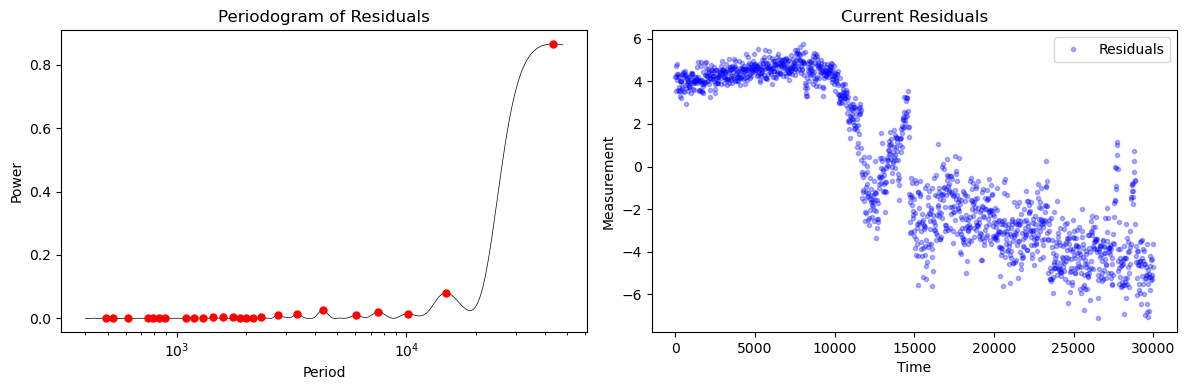


------------------------------------

Possible Peaks sorted by power:
0: 43449.84 (power: 0.87)
1: 14871.16 (power: 0.08)
2: 4321.19 (power: 0.03)
3: 7550.15 (power: 0.02)
4: 10138.79 (power: 0.01)
5: 3355.04 (power: 0.01)
6: 2757.35 (power: 0.01)
7: 6032.52 (power: 0.01)
8: 1432.14 (power: 0.01)
9: 2320.21 (power: 0.00)

------------------------------------

N inferred harmonics: 0

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 43449.84 (power: 0.87)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 41 seconds.


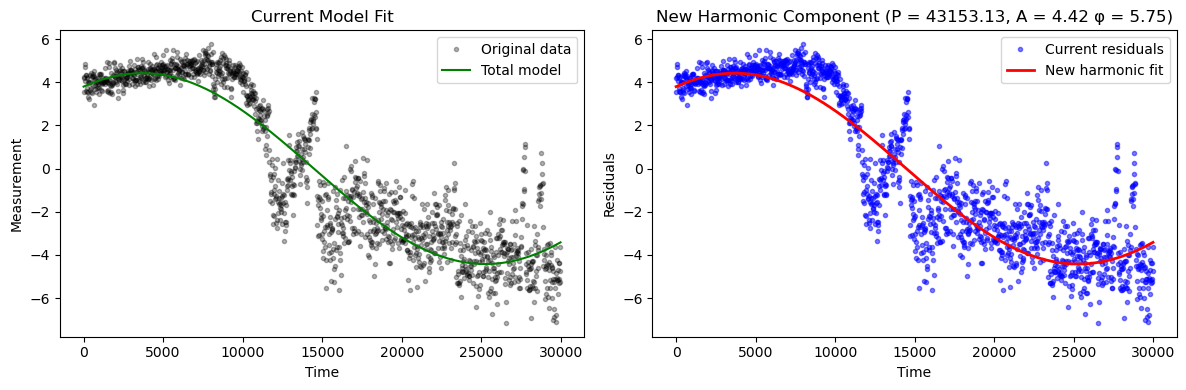


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 43153.13 A = 4.42 phi = 5.75


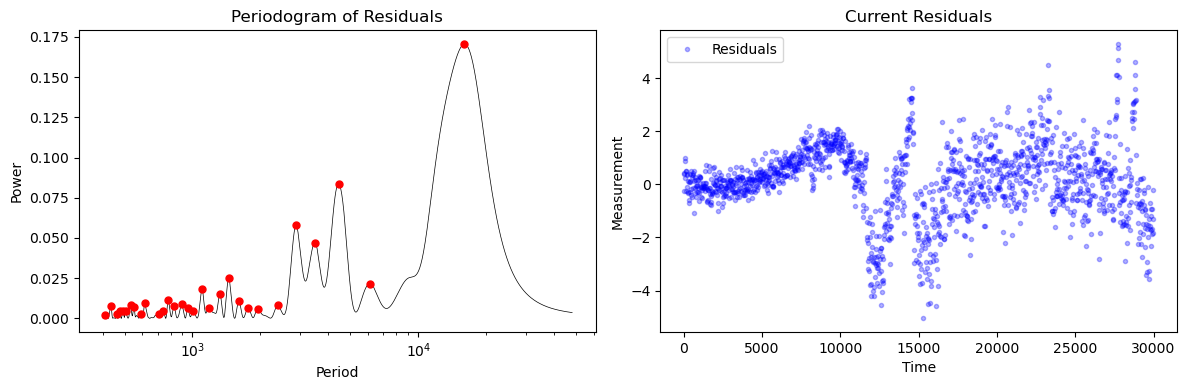


------------------------------------

Possible Peaks sorted by power:
0: 16016.76 (power: 0.17)
1: 4433.27 (power: 0.08)
2: 2874.87 (power: 0.06)
3: 3480.09 (power: 0.05)
4: 1446.63 (power: 0.02)
5: 6101.87 (power: 0.02)
6: 1103.19 (power: 0.02)
7: 1322.63 (power: 0.02)
8: 781.45 (power: 0.01)
9: 1605.43 (power: 0.01)

------------------------------------

N inferred harmonics: 1
Of periods:
  1: 43153

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 16016.76 (power: 0.17)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 37 seconds.


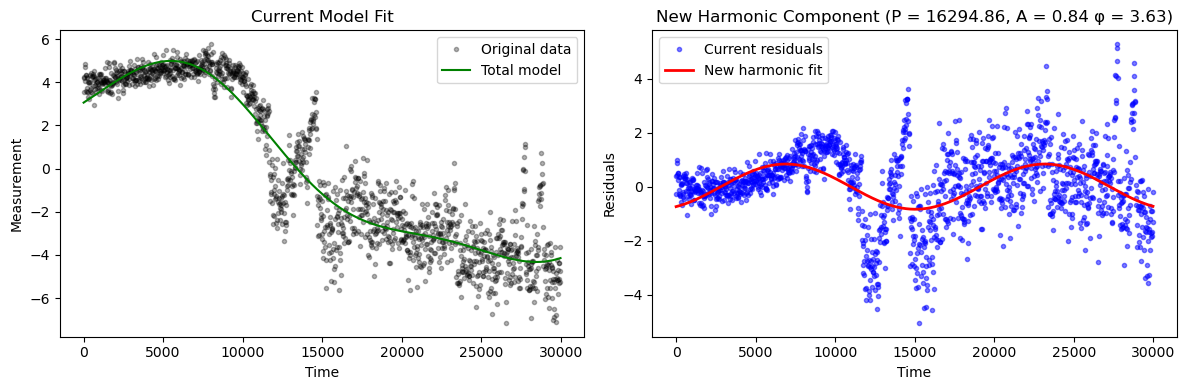


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 16294.86 A = 0.84 phi = 3.63


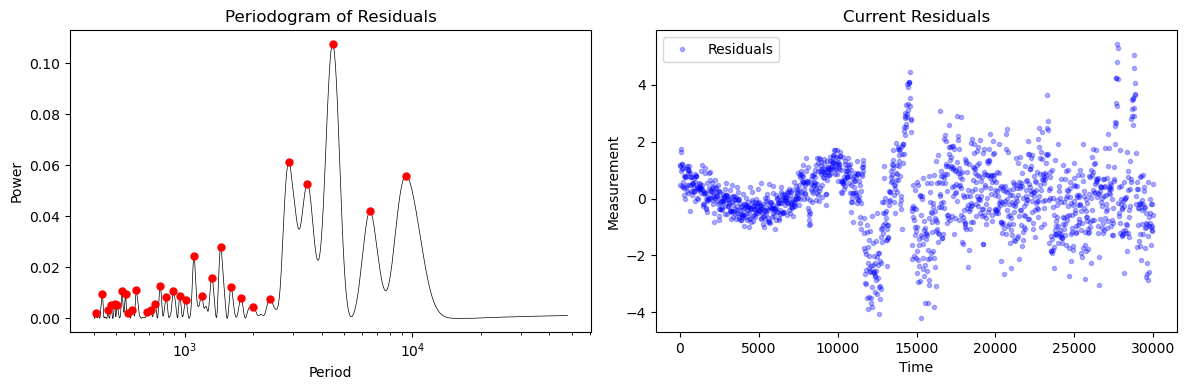


------------------------------------

Possible Peaks sorted by power:
0: 4465.67 (power: 0.11)
1: 2866.29 (power: 0.06)
2: 9379.61 (power: 0.06)
3: 3460.98 (power: 0.05)
4: 6511.66 (power: 0.04)
5: 1440.43 (power: 0.03)
6: 1100.18 (power: 0.02)
7: 1317.45 (power: 0.02)
8: 782.60 (power: 0.01)
9: 1601.35 (power: 0.01)

------------------------------------

N inferred harmonics: 2
Of periods:
  1: 43153
  2: 16295

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 4465.67 (power: 0.11)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 39 seconds.


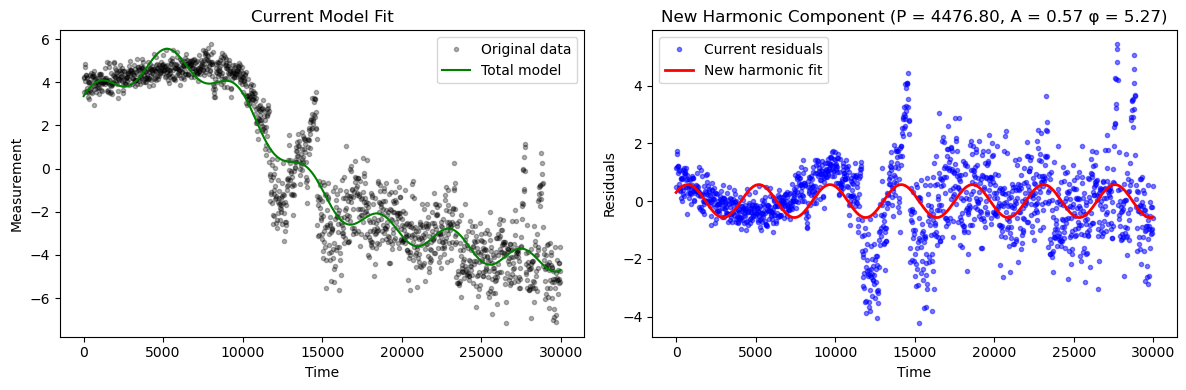


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 4476.80 A = 0.57 phi = 5.27


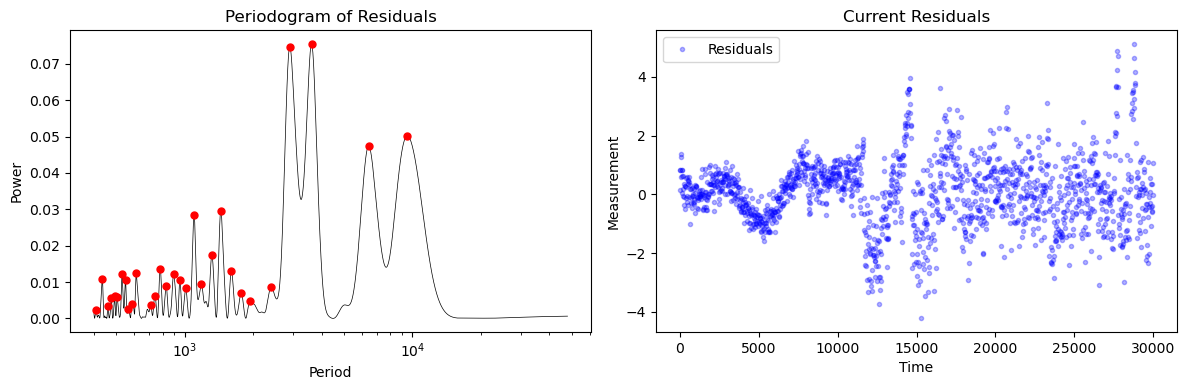


------------------------------------

Possible Peaks sorted by power:
0: 3609.00 (power: 0.08)
1: 2898.00 (power: 0.07)
2: 9507.85 (power: 0.05)
3: 6428.64 (power: 0.05)
4: 1442.80 (power: 0.03)
5: 1100.79 (power: 0.03)
6: 1317.79 (power: 0.02)
7: 781.81 (power: 0.01)
8: 1606.20 (power: 0.01)
9: 613.82 (power: 0.01)

------------------------------------

N inferred harmonics: 3
Of periods:
  1: 43153
  2: 16295
  3: 4477

------------------------------------



Select (0-9)  Use '-1' to finish:  3


Initializing NUTS using jitter+adapt_diag...



Selected period: 6428.64 (power: 0.05)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 36 seconds.


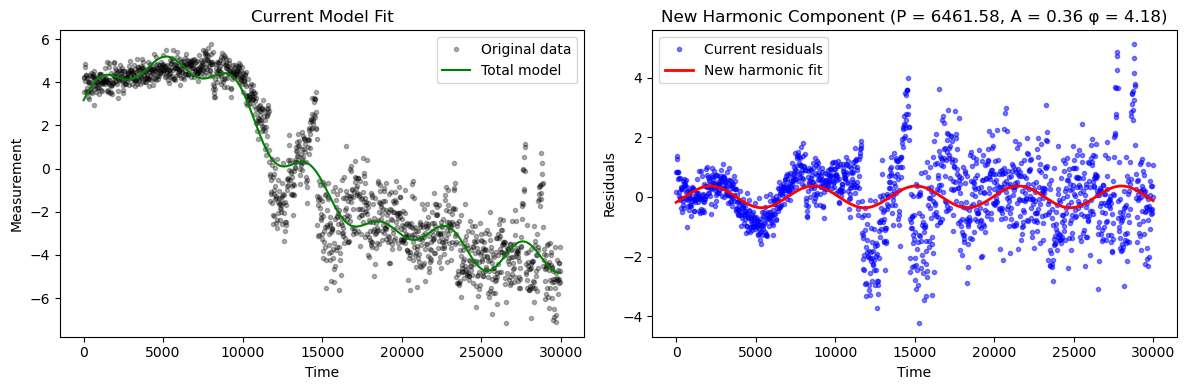


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 6461.58 A = 0.36 phi = 4.18


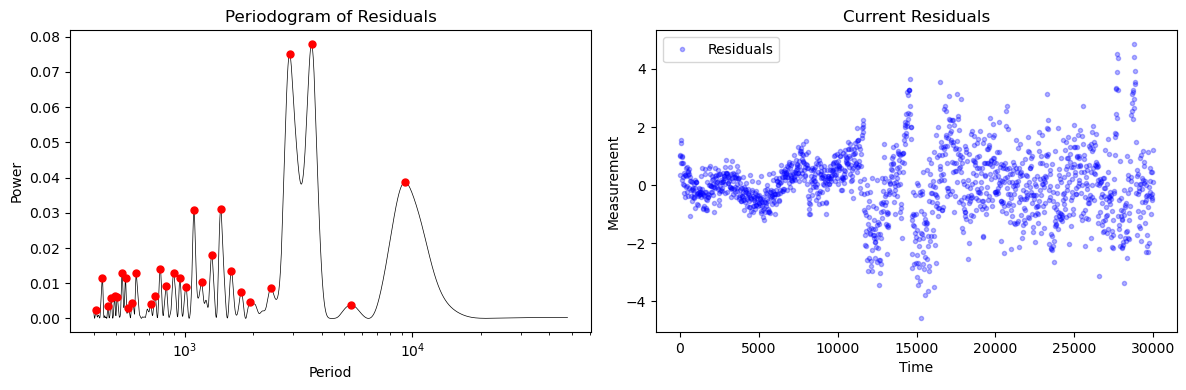


------------------------------------

Possible Peaks sorted by power:
0: 3609.00 (power: 0.08)
1: 2890.53 (power: 0.08)
2: 9284.61 (power: 0.04)
3: 1441.15 (power: 0.03)
4: 1100.30 (power: 0.03)
5: 1315.90 (power: 0.02)
6: 782.11 (power: 0.01)
7: 1605.05 (power: 0.01)
8: 531.75 (power: 0.01)
9: 613.61 (power: 0.01)

------------------------------------

N inferred harmonics: 4
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462

------------------------------------



Select (0-9)  Use '-1' to finish:  2


Initializing NUTS using jitter+adapt_diag...



Selected period: 9284.61 (power: 0.04)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 37 seconds.


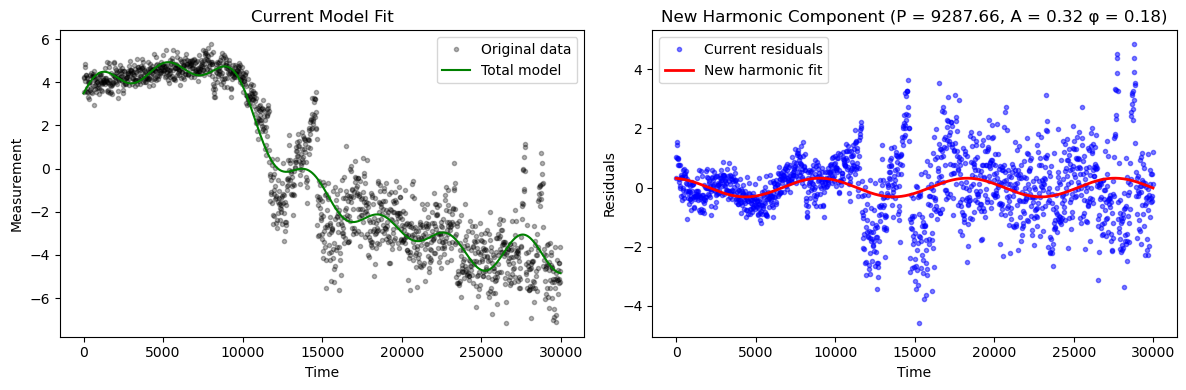


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 9287.66 A = 0.32 phi = 0.18


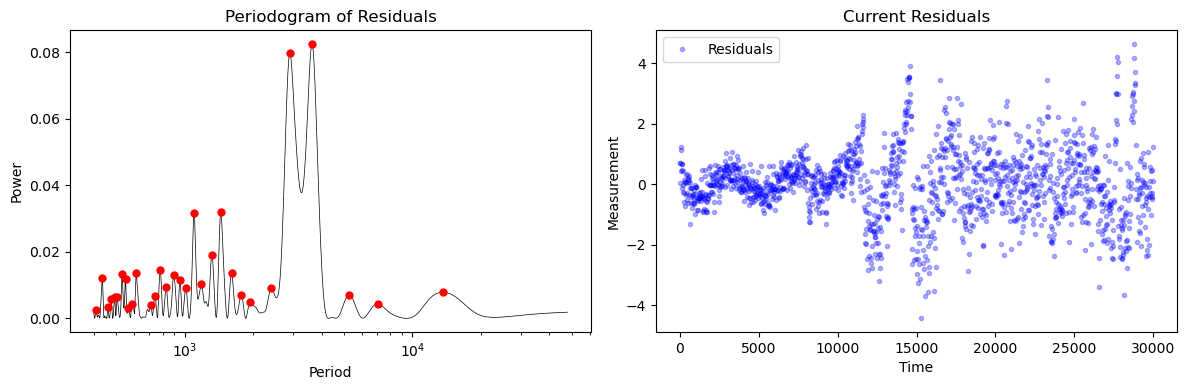


------------------------------------

Possible Peaks sorted by power:
0: 3627.17 (power: 0.08)
1: 2900.09 (power: 0.08)
2: 1443.00 (power: 0.03)
3: 1101.09 (power: 0.03)
4: 1317.53 (power: 0.02)
5: 781.51 (power: 0.01)
6: 1607.09 (power: 0.01)
7: 613.84 (power: 0.01)
8: 531.92 (power: 0.01)
9: 896.10 (power: 0.01)

------------------------------------

N inferred harmonics: 5
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 3627.17 (power: 0.08)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 37 seconds.


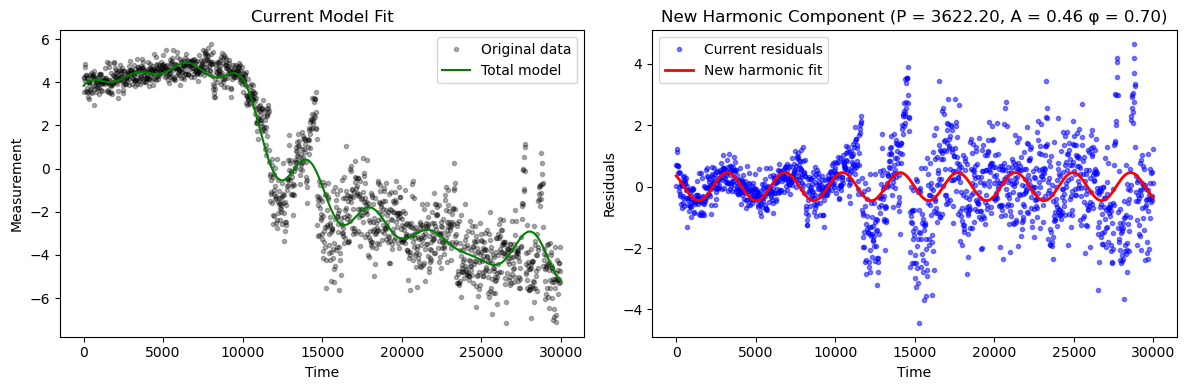


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 3622.20 A = 0.46 phi = 0.70


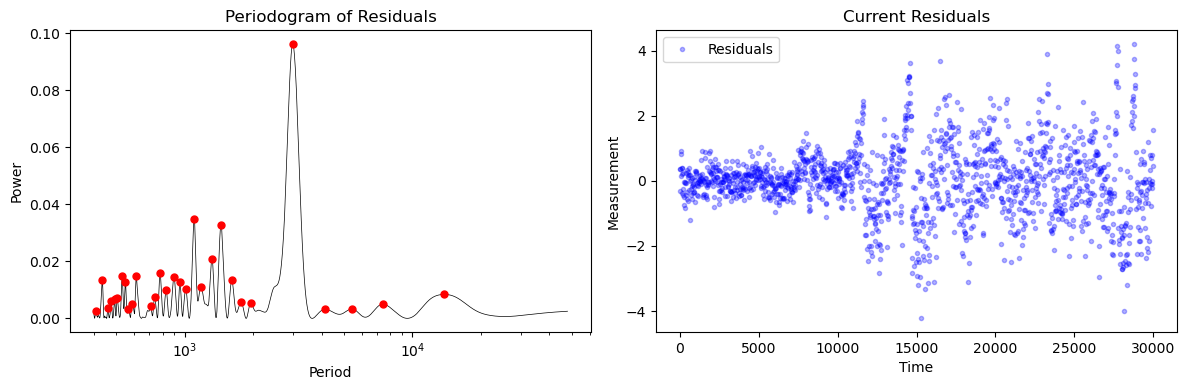


------------------------------------

Possible Peaks sorted by power:
0: 2984.64 (power: 0.10)
1: 1101.93 (power: 0.03)
2: 1445.38 (power: 0.03)
3: 1319.08 (power: 0.02)
4: 780.72 (power: 0.02)
5: 614.02 (power: 0.01)
6: 532.15 (power: 0.01)
7: 898.25 (power: 0.01)
8: 435.39 (power: 0.01)
9: 1611.72 (power: 0.01)

------------------------------------

N inferred harmonics: 6
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 2984.64 (power: 0.10)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 44 seconds.


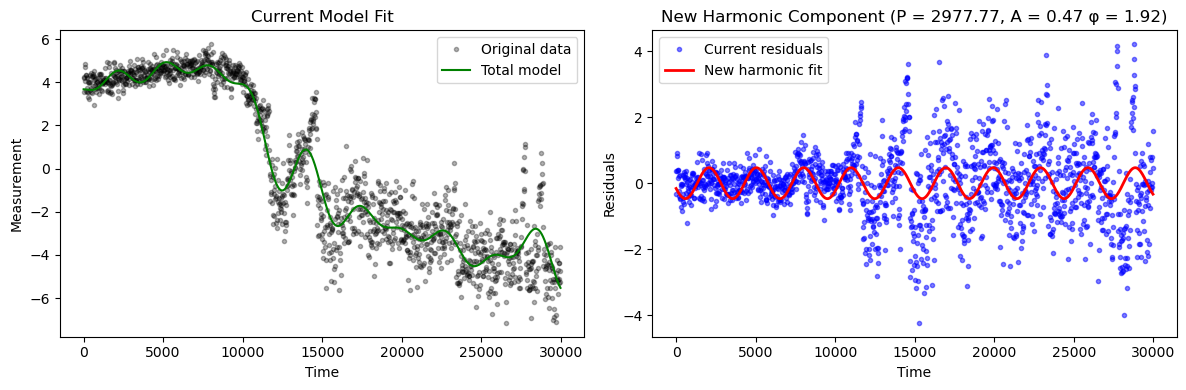


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 2977.77 A = 0.47 phi = 1.92


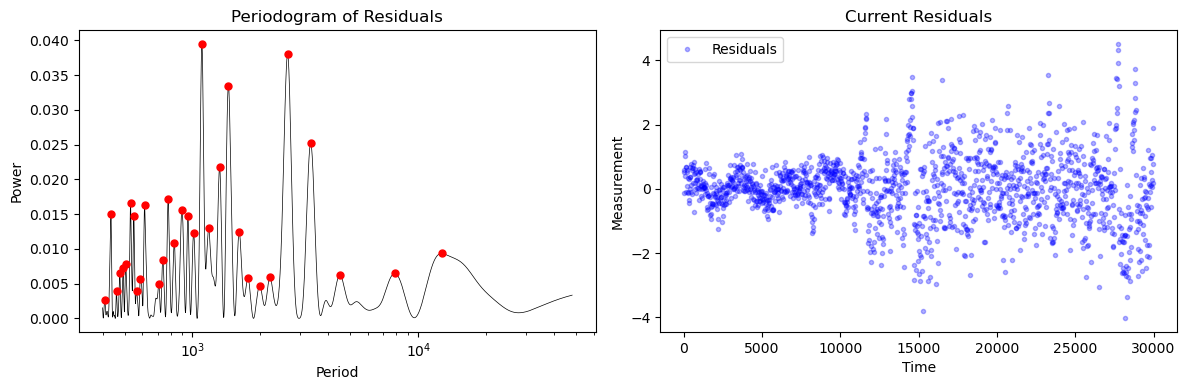


------------------------------------

Possible Peaks sorted by power:
0: 1100.97 (power: 0.04)
1: 2636.93 (power: 0.04)
2: 1442.49 (power: 0.03)
3: 3337.27 (power: 0.03)
4: 1318.39 (power: 0.02)
5: 780.87 (power: 0.02)
6: 532.11 (power: 0.02)
7: 613.82 (power: 0.02)
8: 898.21 (power: 0.02)
9: 435.51 (power: 0.01)

------------------------------------

N inferred harmonics: 7
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 1100.97 (power: 0.04)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 43 seconds.


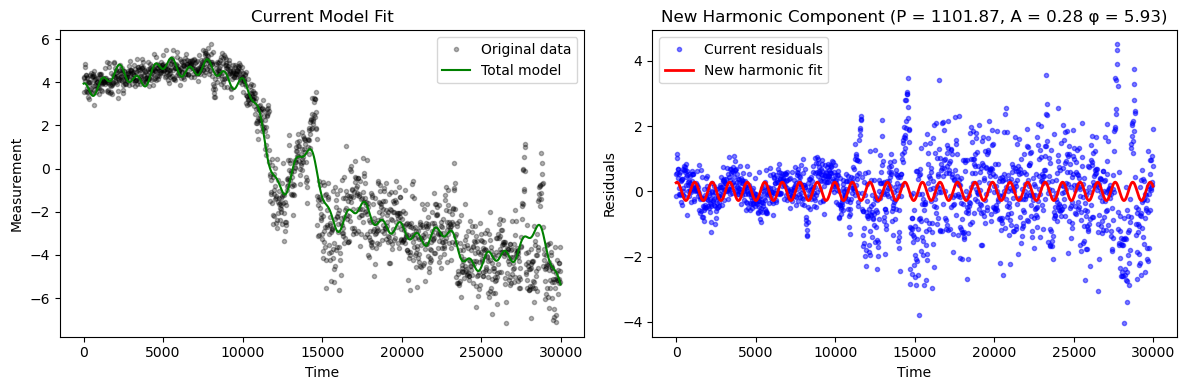


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 1101.87 A = 0.28 phi = 5.93


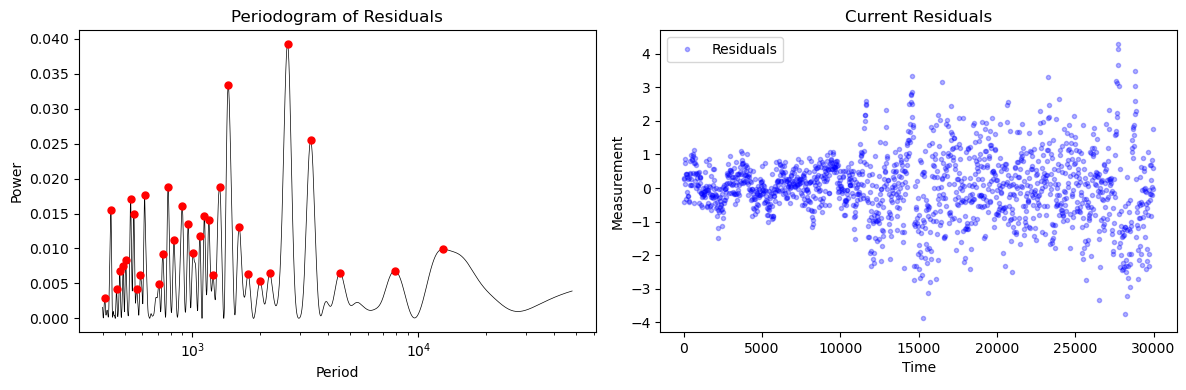


------------------------------------

Possible Peaks sorted by power:
0: 2635.90 (power: 0.04)
1: 1440.33 (power: 0.03)
2: 3336.72 (power: 0.03)
3: 779.90 (power: 0.02)
4: 1317.36 (power: 0.02)
5: 614.10 (power: 0.02)
6: 532.32 (power: 0.02)
7: 900.22 (power: 0.02)
8: 435.40 (power: 0.02)
9: 550.15 (power: 0.01)

------------------------------------

N inferred harmonics: 8
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 2635.90 (power: 0.04)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 39 seconds.


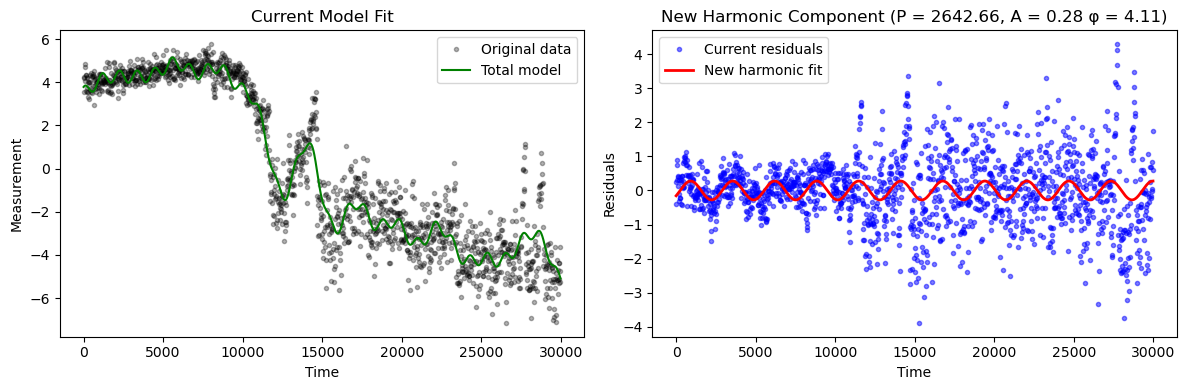


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 2642.66 A = 0.28 phi = 4.11


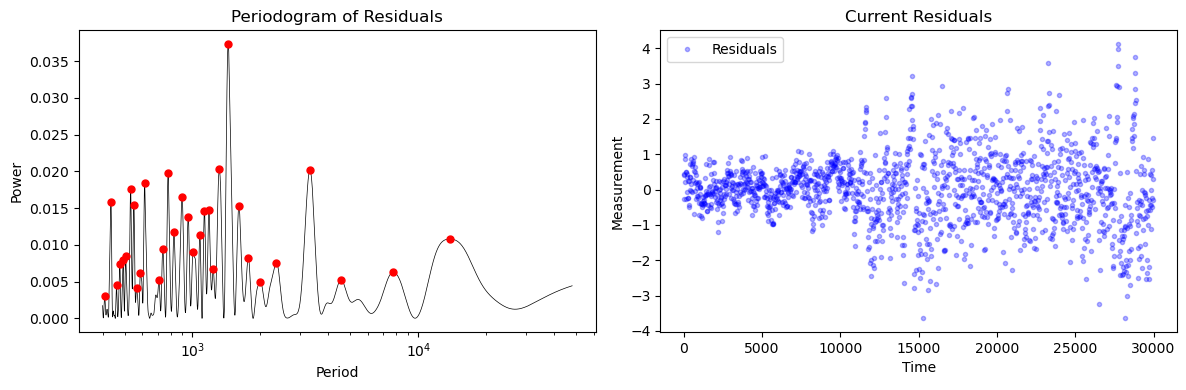


------------------------------------

Possible Peaks sorted by power:
0: 1439.40 (power: 0.04)
1: 1315.21 (power: 0.02)
2: 3312.06 (power: 0.02)
3: 780.18 (power: 0.02)
4: 614.04 (power: 0.02)
5: 532.20 (power: 0.02)
6: 899.17 (power: 0.02)
7: 435.41 (power: 0.02)
8: 550.26 (power: 0.02)
9: 1605.69 (power: 0.02)

------------------------------------

N inferred harmonics: 9
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 1439.40 (power: 0.04)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 42 seconds.


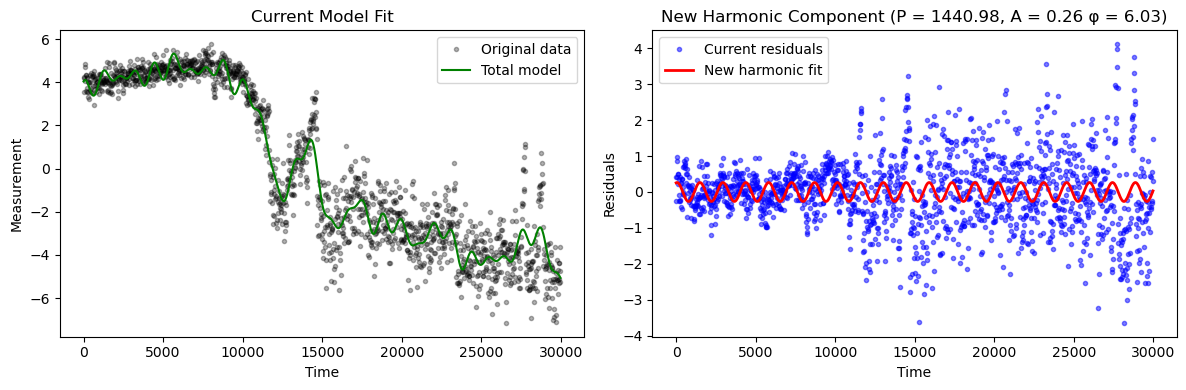


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 1440.98 A = 0.26 phi = 6.03


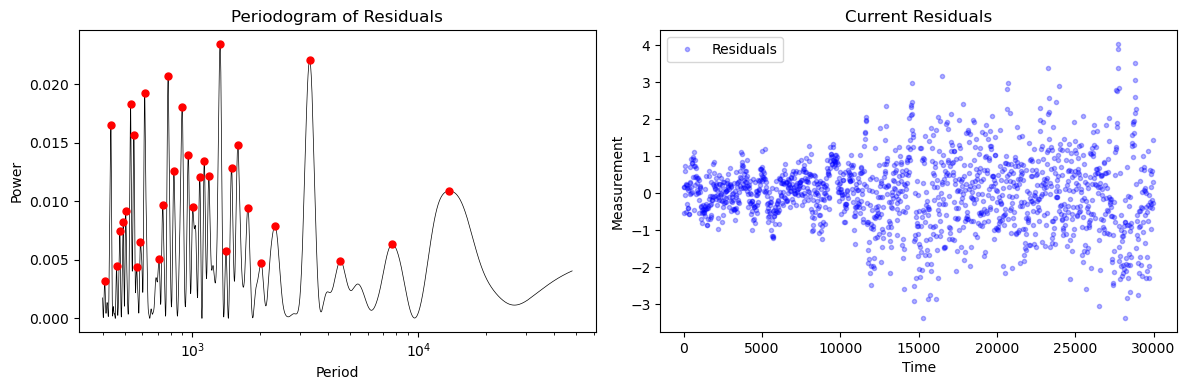


------------------------------------

Possible Peaks sorted by power:
0: 1324.89 (power: 0.02)
1: 3302.30 (power: 0.02)
2: 779.81 (power: 0.02)
3: 614.25 (power: 0.02)
4: 532.35 (power: 0.02)
5: 899.97 (power: 0.02)
6: 435.27 (power: 0.02)
7: 550.17 (power: 0.02)
8: 1588.99 (power: 0.01)
9: 958.08 (power: 0.01)

------------------------------------

N inferred harmonics: 10
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 1324.89 (power: 0.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 47 seconds.


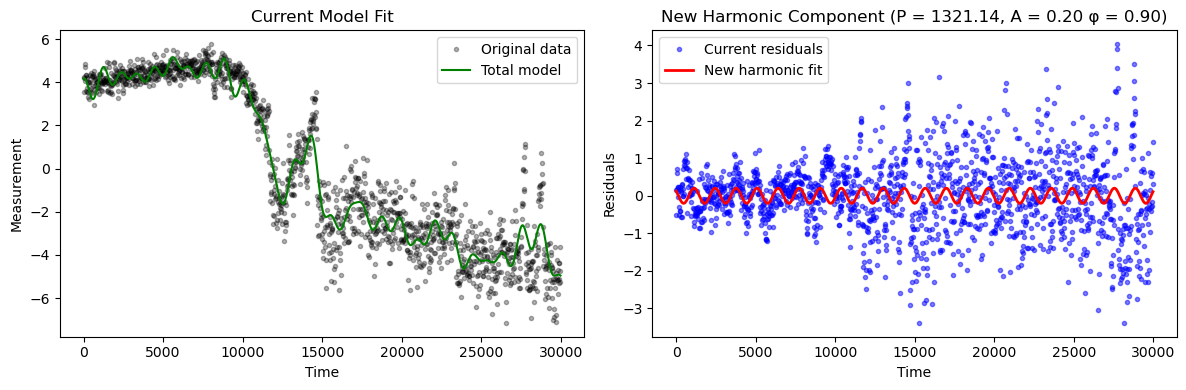


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 1321.14 A = 0.20 phi = 0.90


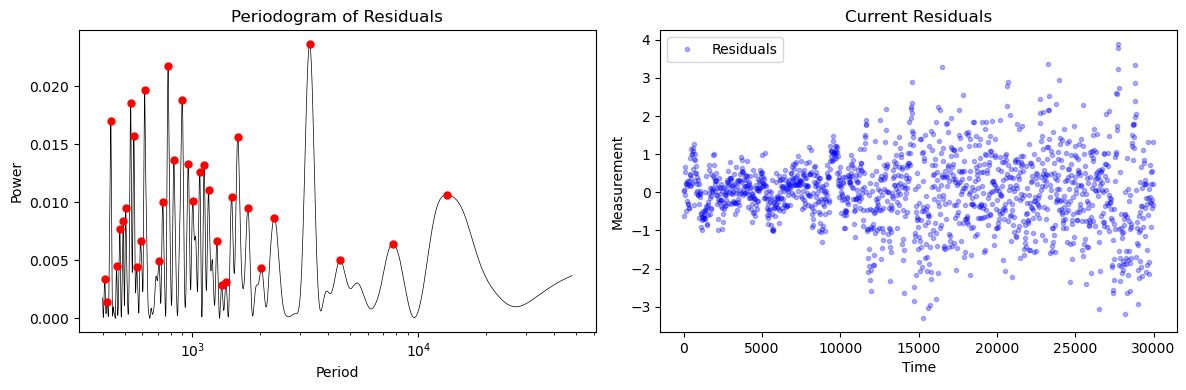


------------------------------------

Possible Peaks sorted by power:
0: 3301.76 (power: 0.02)
1: 779.90 (power: 0.02)
2: 614.45 (power: 0.02)
3: 900.58 (power: 0.02)
4: 532.42 (power: 0.02)
5: 435.19 (power: 0.02)
6: 550.06 (power: 0.02)
7: 1587.24 (power: 0.02)
8: 827.59 (power: 0.01)
9: 958.03 (power: 0.01)

------------------------------------

N inferred harmonics: 11
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441
  11: 1321

------------------------------------



Select (0-9)  Use '-1' to finish:  1


Initializing NUTS using jitter+adapt_diag...



Selected period: 779.90 (power: 0.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 45 seconds.


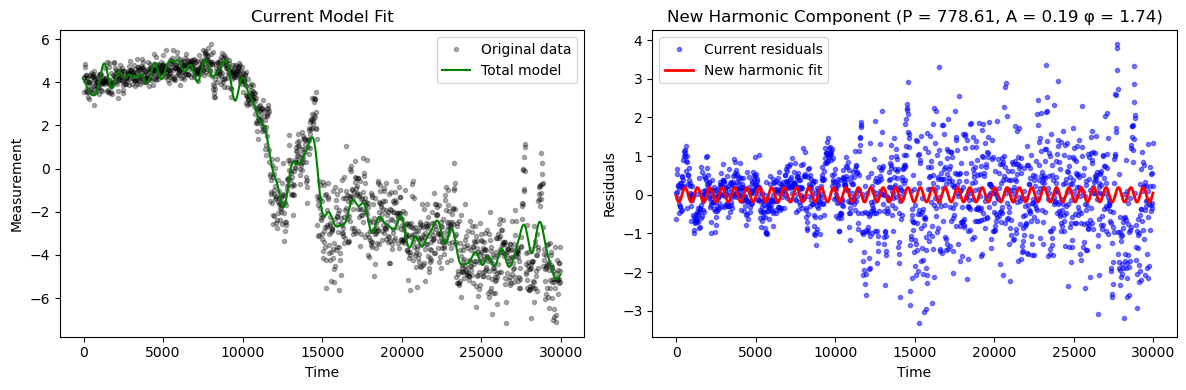


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 778.61 A = 0.19 phi = 1.74


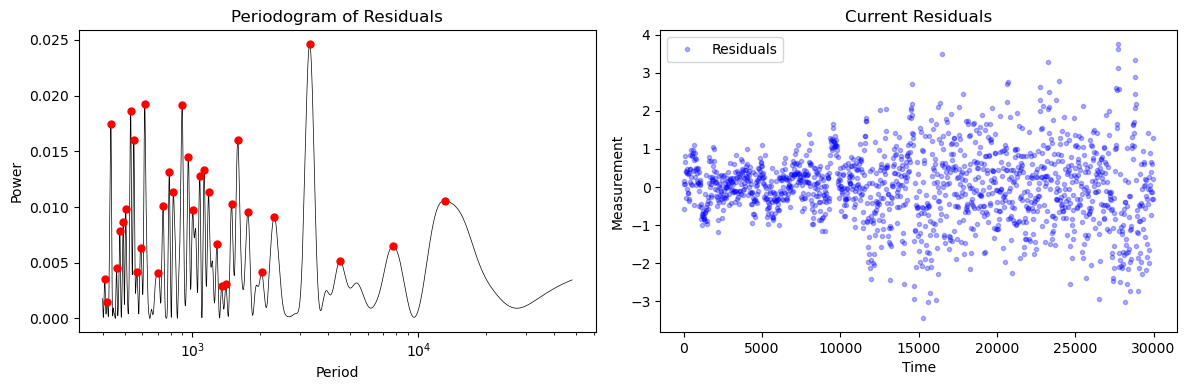


------------------------------------

Possible Peaks sorted by power:
0: 3303.38 (power: 0.02)
1: 614.73 (power: 0.02)
2: 899.97 (power: 0.02)
3: 532.34 (power: 0.02)
4: 435.18 (power: 0.02)
5: 549.90 (power: 0.02)
6: 1586.99 (power: 0.02)
7: 959.03 (power: 0.01)
8: 1126.74 (power: 0.01)
9: 789.65 (power: 0.01)

------------------------------------

N inferred harmonics: 12
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441
  11: 1321
  12: 779

------------------------------------



Select (0-9)  Use '-1' to finish:  1


Initializing NUTS using jitter+adapt_diag...



Selected period: 614.73 (power: 0.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 42 seconds.


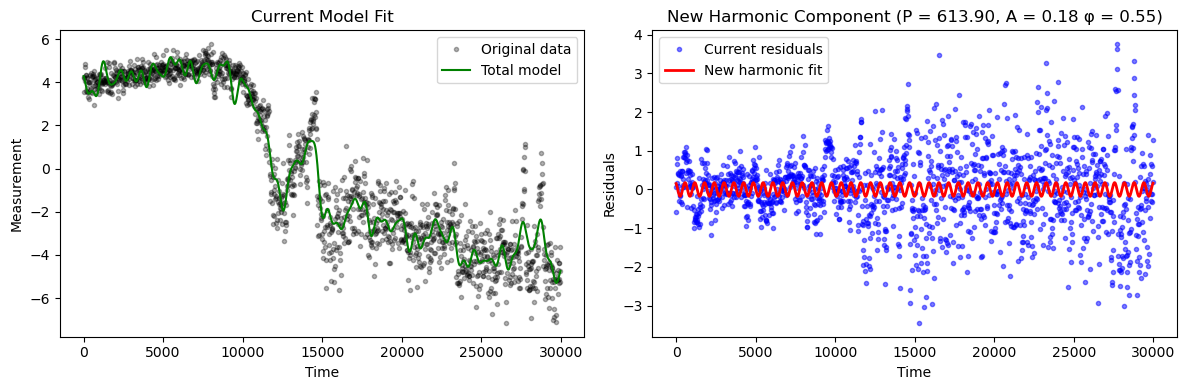


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 613.90 A = 0.18 phi = 0.55


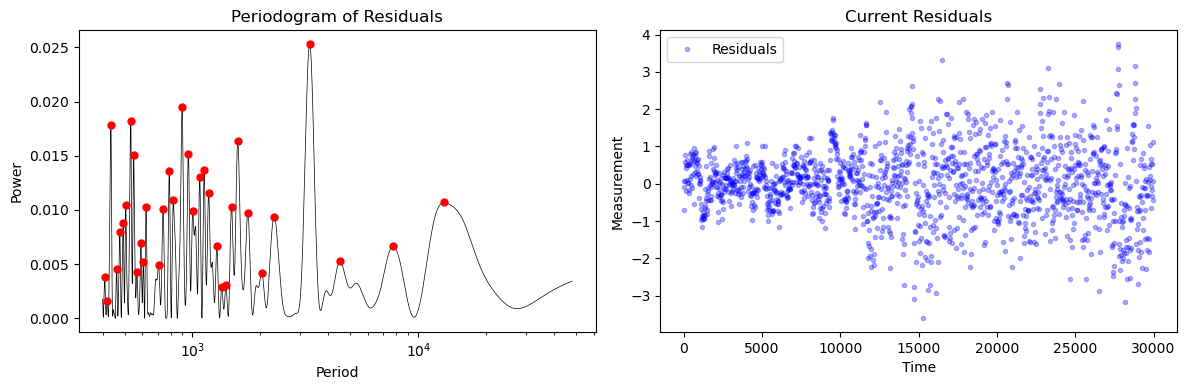


------------------------------------

Possible Peaks sorted by power:
0: 3302.84 (power: 0.03)
1: 899.77 (power: 0.02)
2: 532.66 (power: 0.02)
3: 435.02 (power: 0.02)
4: 1586.99 (power: 0.02)
5: 958.94 (power: 0.02)
6: 549.33 (power: 0.02)
7: 1126.93 (power: 0.01)
8: 789.46 (power: 0.01)
9: 1076.40 (power: 0.01)

------------------------------------

N inferred harmonics: 13
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441
  11: 1321
  12: 779
  13: 614

------------------------------------



Select (0-9)  Use '-1' to finish:  1


Initializing NUTS using jitter+adapt_diag...



Selected period: 899.77 (power: 0.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 41 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


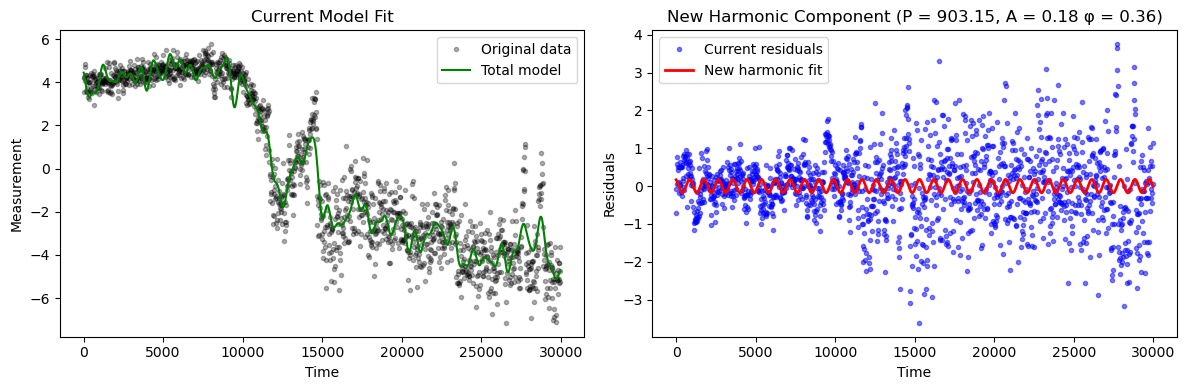


------------------------------------


Keep this fit? (y/n/r: refit with new period):  n



------------------------------------
Discarding this fit


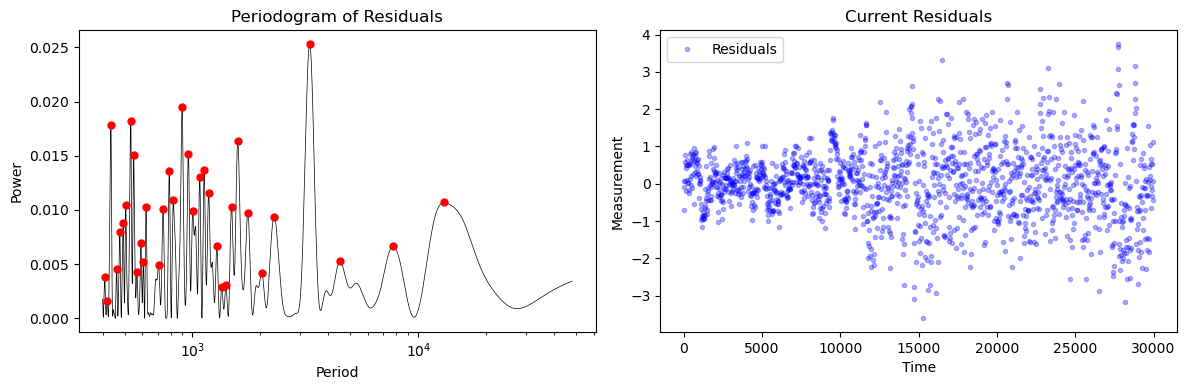


------------------------------------

Possible Peaks sorted by power:
0: 3302.84 (power: 0.03)
1: 899.77 (power: 0.02)
2: 532.66 (power: 0.02)
3: 435.02 (power: 0.02)
4: 1586.99 (power: 0.02)
5: 958.94 (power: 0.02)
6: 549.33 (power: 0.02)
7: 1126.93 (power: 0.01)
8: 789.46 (power: 0.01)
9: 1076.40 (power: 0.01)

------------------------------------

N inferred harmonics: 13
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441
  11: 1321
  12: 779
  13: 614

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 3302.84 (power: 0.03)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 38 seconds.


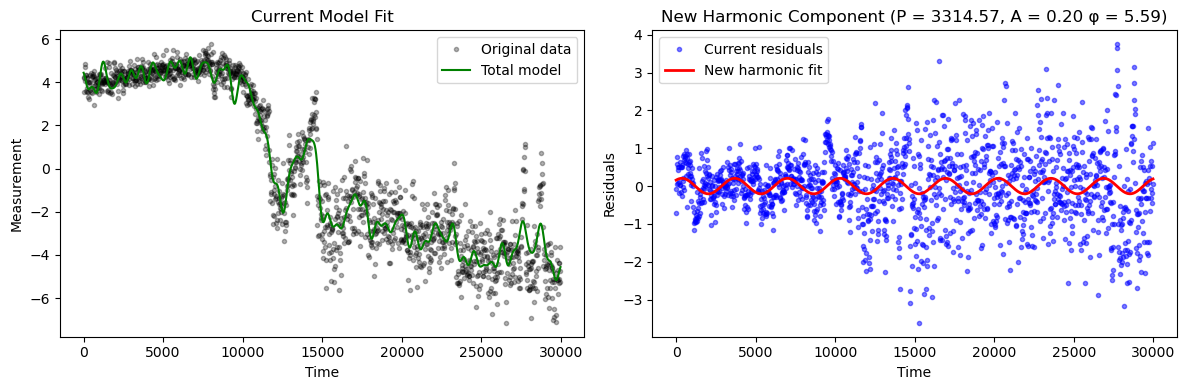


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 3314.57 A = 0.20 phi = 5.59


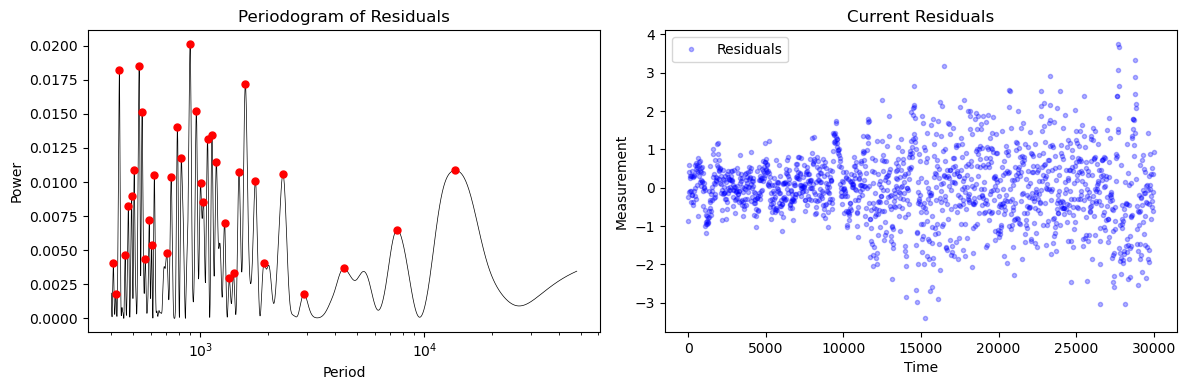


------------------------------------

Possible Peaks sorted by power:
0: 899.81 (power: 0.02)
1: 532.74 (power: 0.02)
2: 434.93 (power: 0.02)
3: 1588.49 (power: 0.02)
4: 959.31 (power: 0.02)
5: 549.26 (power: 0.02)
6: 789.68 (power: 0.01)
7: 1126.68 (power: 0.01)
8: 1076.23 (power: 0.01)
9: 822.80 (power: 0.01)

------------------------------------

N inferred harmonics: 14
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441
  11: 1321
  12: 779
  13: 614
  14: 3315

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 899.81 (power: 0.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 40 seconds.


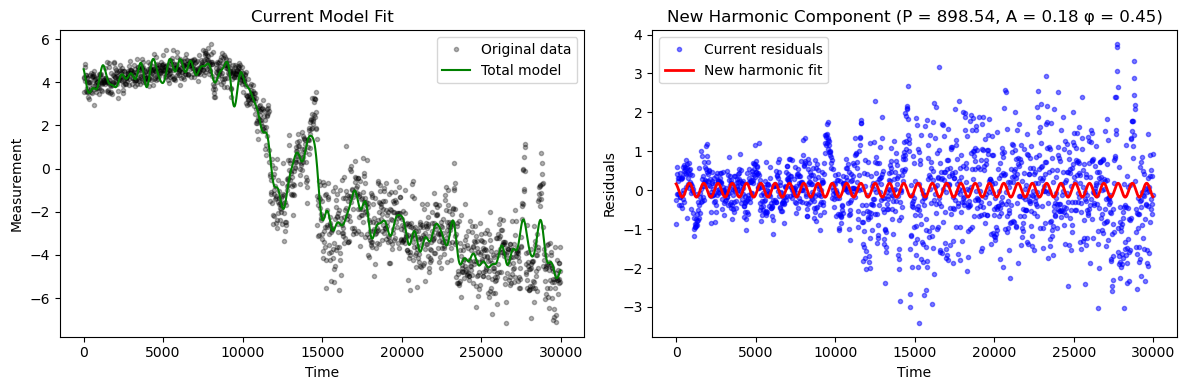


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 898.54 A = 0.18 phi = 0.45


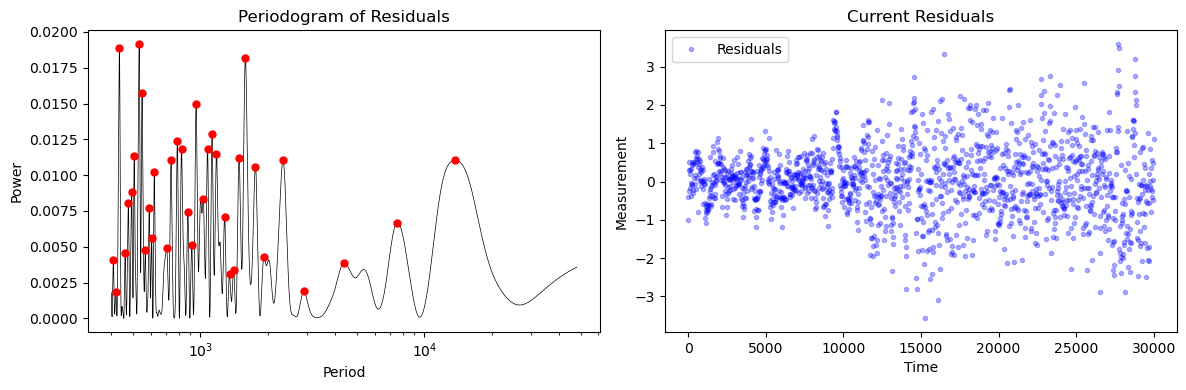


------------------------------------

Possible Peaks sorted by power:
0: 532.97 (power: 0.02)
1: 434.92 (power: 0.02)
2: 1588.74 (power: 0.02)
3: 549.08 (power: 0.02)
4: 957.21 (power: 0.01)
5: 1127.49 (power: 0.01)
6: 789.31 (power: 0.01)
7: 823.60 (power: 0.01)
8: 1076.29 (power: 0.01)
9: 1180.21 (power: 0.01)

------------------------------------

N inferred harmonics: 15
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441
  11: 1321
  12: 779
  13: 614
  14: 3315
  15: 899

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 532.97 (power: 0.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 43 seconds.


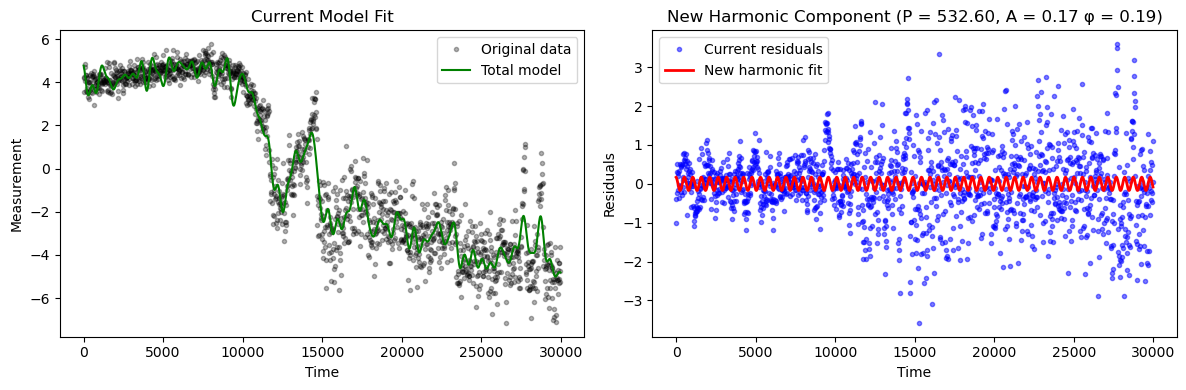


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 532.60 A = 0.17 phi = 0.19


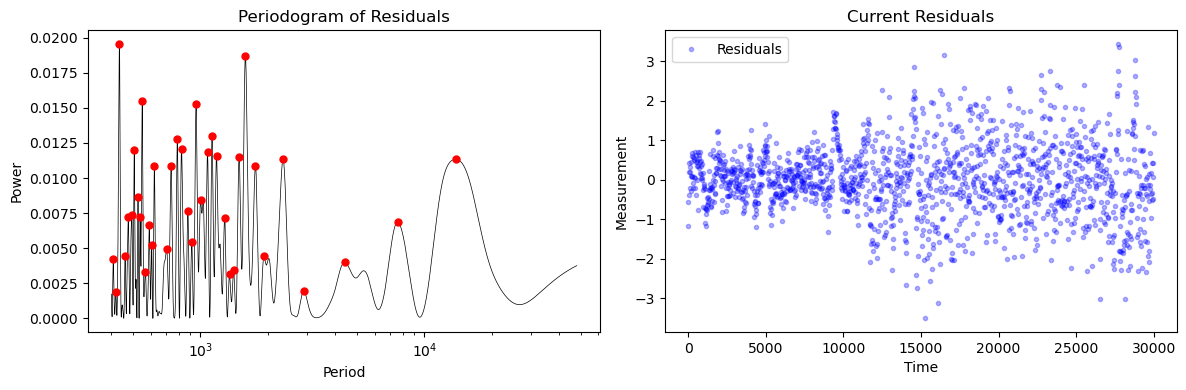


------------------------------------

Possible Peaks sorted by power:
0: 434.90 (power: 0.02)
1: 1588.99 (power: 0.02)
2: 549.94 (power: 0.02)
3: 956.89 (power: 0.02)
4: 1127.56 (power: 0.01)
5: 789.40 (power: 0.01)
6: 823.70 (power: 0.01)
7: 506.70 (power: 0.01)
8: 1076.12 (power: 0.01)
9: 1180.42 (power: 0.01)

------------------------------------

N inferred harmonics: 16
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441
  11: 1321
  12: 779
  13: 614
  14: 3315
  15: 899
  16: 533

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 434.90 (power: 0.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 49 seconds.


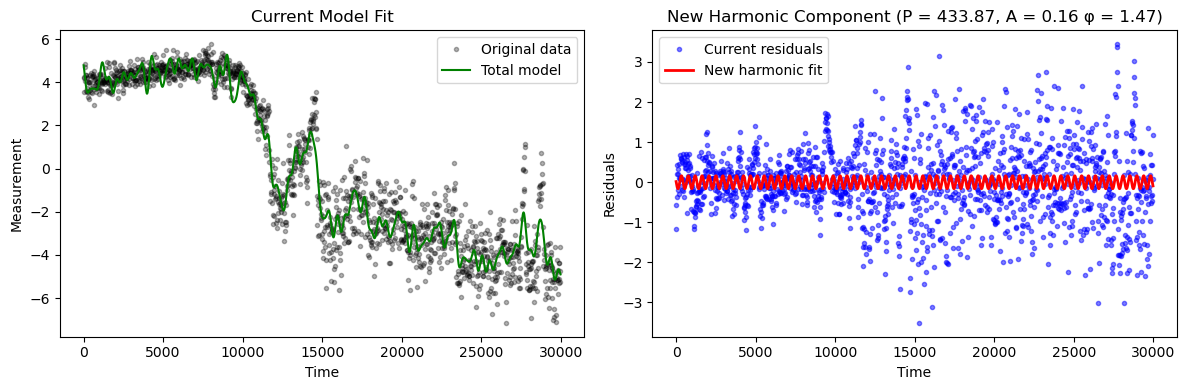


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 433.87 A = 0.16 phi = 1.47


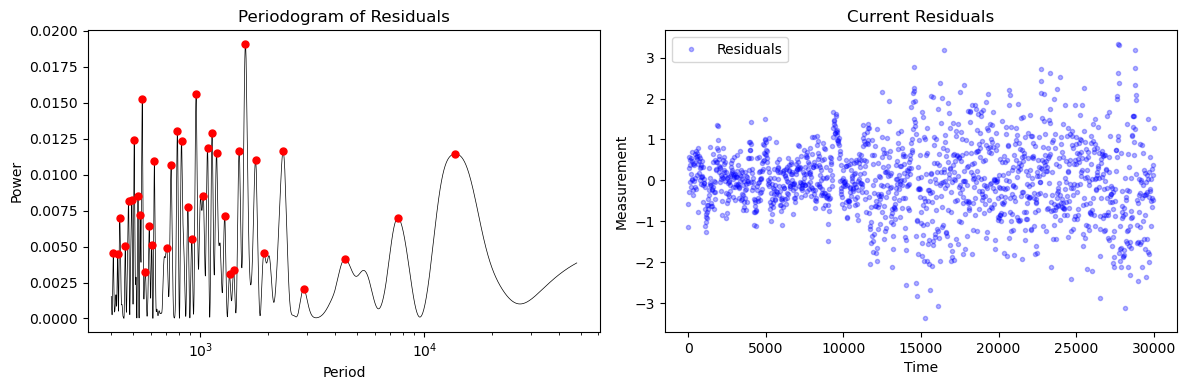


------------------------------------

Possible Peaks sorted by power:
0: 1589.49 (power: 0.02)
1: 956.85 (power: 0.02)
2: 550.03 (power: 0.02)
3: 789.58 (power: 0.01)
4: 1127.56 (power: 0.01)
5: 506.48 (power: 0.01)
6: 823.57 (power: 0.01)
7: 1075.94 (power: 0.01)
8: 1489.91 (power: 0.01)
9: 2341.77 (power: 0.01)

------------------------------------

N inferred harmonics: 17
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441
  11: 1321
  12: 779
  13: 614
  14: 3315
  15: 899
  16: 533
  17: 434

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 1589.49 (power: 0.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 36 seconds.


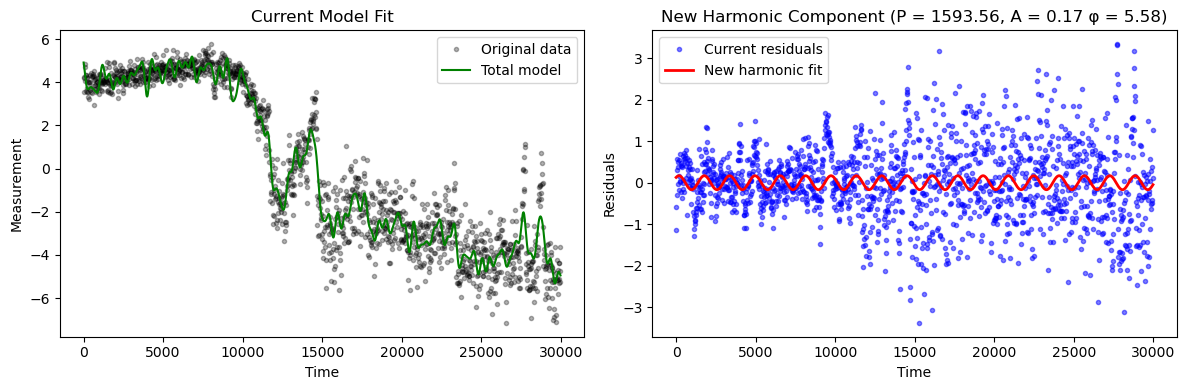


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 1593.56 A = 0.17 phi = 5.58


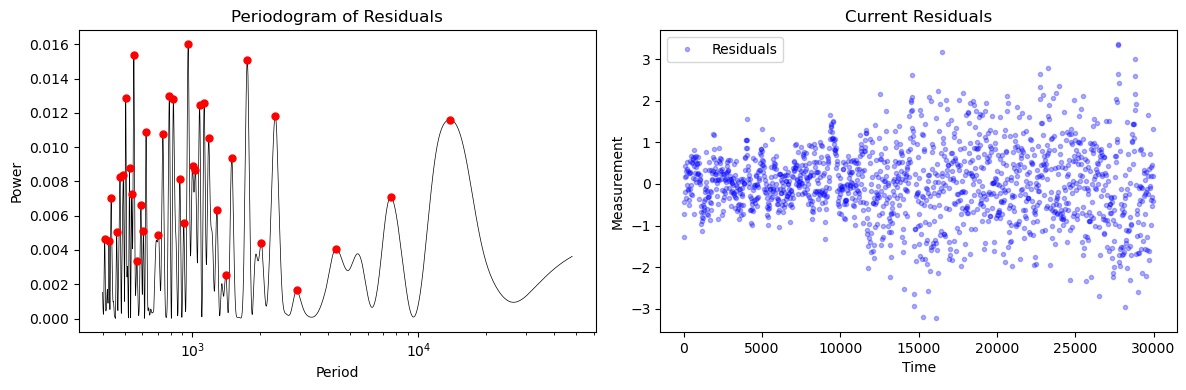


------------------------------------

Possible Peaks sorted by power:
0: 957.03 (power: 0.02)
1: 550.00 (power: 0.02)
2: 1748.36 (power: 0.02)
3: 789.83 (power: 0.01)
4: 506.47 (power: 0.01)
5: 823.53 (power: 0.01)
6: 1126.68 (power: 0.01)
7: 1075.14 (power: 0.01)
8: 2325.03 (power: 0.01)
9: 13793.07 (power: 0.01)

------------------------------------

N inferred harmonics: 18
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441
  11: 1321
  12: 779
  13: 614
  14: 3315
  15: 899
  16: 533
  17: 434
  18: 1594

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 957.03 (power: 0.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 37 seconds.


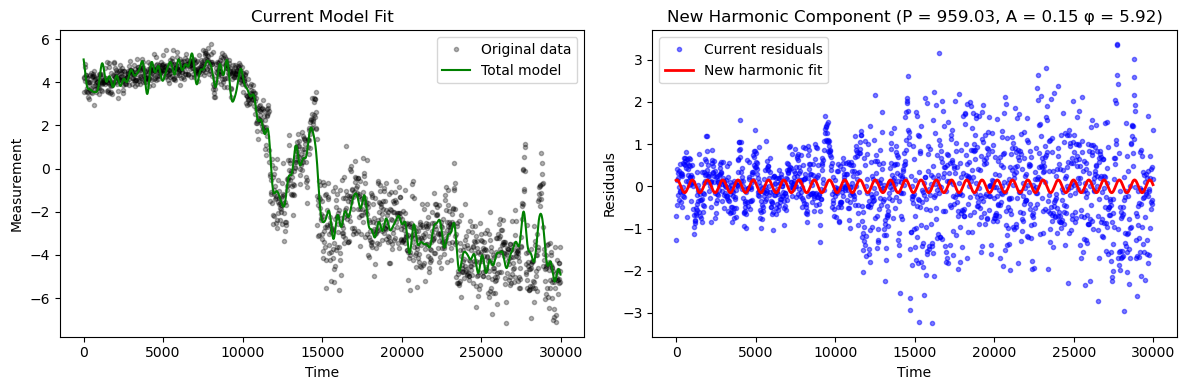


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 959.03 A = 0.15 phi = 5.92


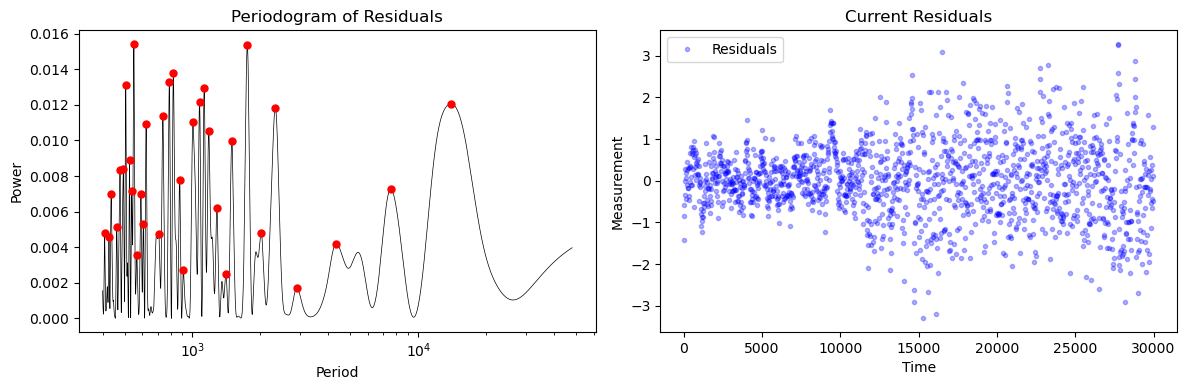


------------------------------------

Possible Peaks sorted by power:
0: 550.00 (power: 0.02)
1: 1749.27 (power: 0.02)
2: 822.83 (power: 0.01)
3: 790.11 (power: 0.01)
4: 506.46 (power: 0.01)
5: 1126.68 (power: 0.01)
6: 1074.68 (power: 0.01)
7: 13945.67 (power: 0.01)
8: 2327.17 (power: 0.01)
9: 739.42 (power: 0.01)

------------------------------------

N inferred harmonics: 19
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441
  11: 1321
  12: 779
  13: 614
  14: 3315
  15: 899
  16: 533
  17: 434
  18: 1594
  19: 959

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 550.00 (power: 0.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 45 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


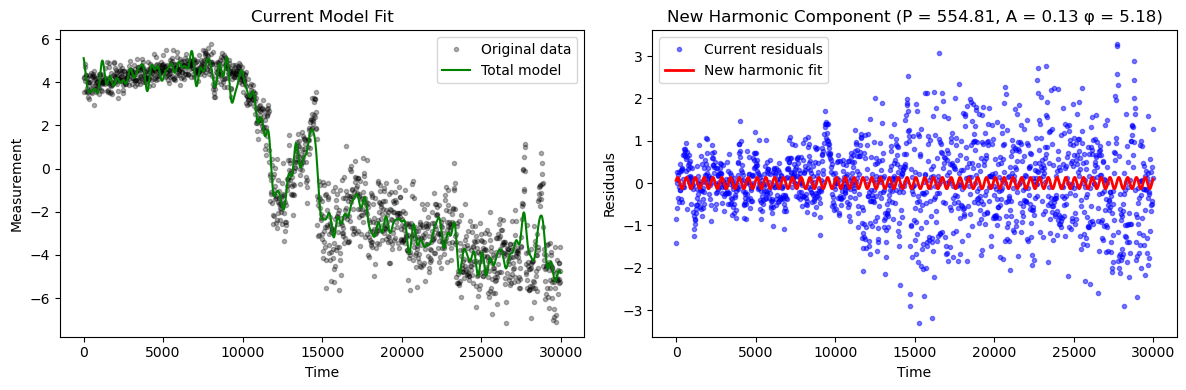


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 554.81 A = 0.13 phi = 5.18


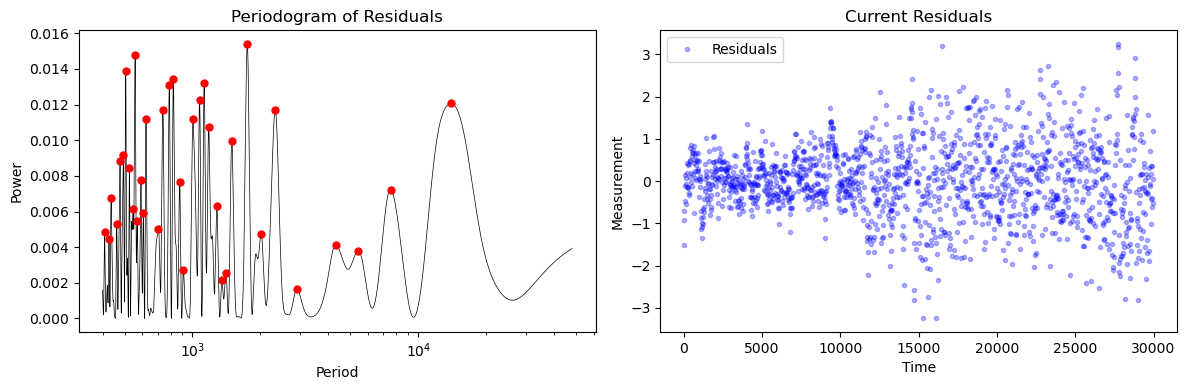


------------------------------------

Possible Peaks sorted by power:
0: 1748.52 (power: 0.02)
1: 557.15 (power: 0.01)
2: 506.19 (power: 0.01)
3: 823.00 (power: 0.01)
4: 1126.74 (power: 0.01)
5: 789.74 (power: 0.01)
6: 1074.97 (power: 0.01)
7: 13964.98 (power: 0.01)
8: 739.50 (power: 0.01)
9: 2325.03 (power: 0.01)

------------------------------------

N inferred harmonics: 20
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441
  11: 1321
  12: 779
  13: 614
  14: 3315
  15: 899
  16: 533
  17: 434
  18: 1594
  19: 959
  20: 555

------------------------------------



Select (0-9)  Use '-1' to finish:  0


Initializing NUTS using jitter+adapt_diag...



Selected period: 1748.52 (power: 0.02)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, phi, sigma, P]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 42 seconds.


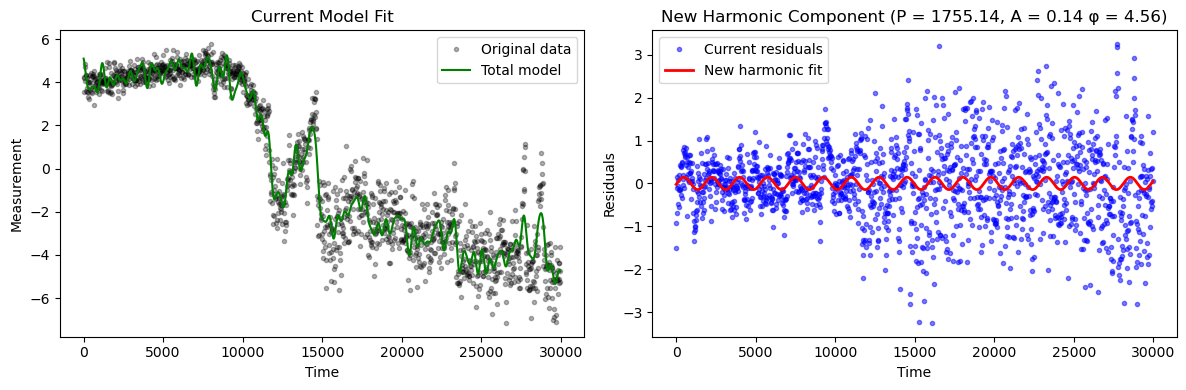


------------------------------------


Keep this fit? (y/n/r: refit with new period):  y



------------------------------------
Added harmonic with P = 1755.14 A = 0.14 phi = 4.56


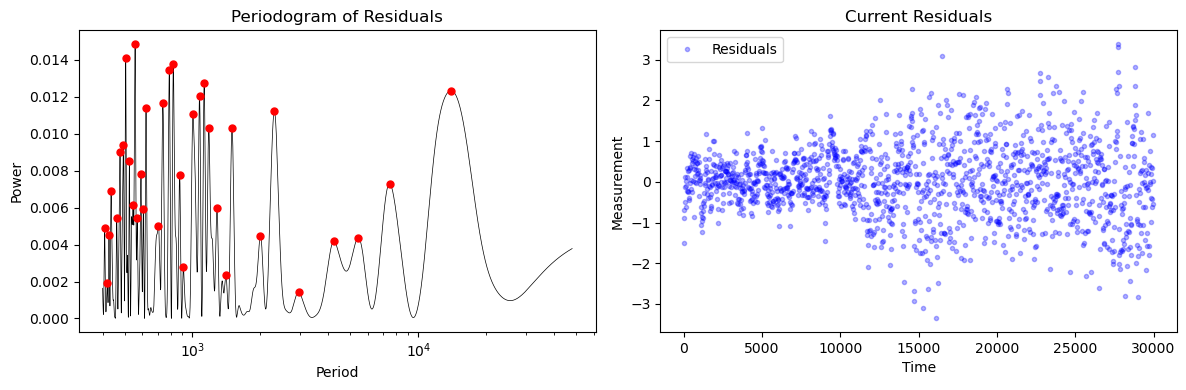


------------------------------------

Possible Peaks sorted by power:
0: 557.13 (power: 0.01)
1: 506.16 (power: 0.01)
2: 822.93 (power: 0.01)
3: 789.89 (power: 0.01)
4: 1126.74 (power: 0.01)
5: 13955.32 (power: 0.01)
6: 1074.51 (power: 0.01)
7: 739.55 (power: 0.01)
8: 622.92 (power: 0.01)
9: 2304.83 (power: 0.01)

------------------------------------

N inferred harmonics: 21
Of periods:
  1: 43153
  2: 16295
  3: 4477
  4: 6462
  5: 9288
  6: 3622
  7: 2978
  8: 1102
  9: 2643
  10: 1441
  11: 1321
  12: 779
  13: 614
  14: 3315
  15: 899
  16: 533
  17: 434
  18: 1594
  19: 959
  20: 555
  21: 1755

------------------------------------



Select (0-9)  Use '-1' to finish:  -1


Finished fitting.


In [6]:
t, y = load_data(n_years=30000)
results = interactive_fit(t, y, n_samples=10000, n_tune=5000, target_accept=0.8)

In [7]:
table = results['param']
table = table.sort_values(by='period', ascending=False)

In [10]:
table

period    s_period  amplitude  s_amplitude       phi     s_phi
0   43153.125621  684.061825   4.419328     0.045661  5.746146  0.034506
1   16294.855366  272.230169   0.837877     0.047570  3.627512  0.126106
4    9287.662606  249.464962   0.316716     0.042055  0.184482  0.261840
3    6461.584673   85.746671   0.364347     0.042689  4.183866  0.196734
2    4476.795385   32.907967   0.569780     0.042674  5.266464  0.183457
5    3622.195360   23.696149   0.456676     0.039979  0.698938  0.170777
13   3314.570536   33.050194   0.204803     0.034087  5.587900  0.315511
6    2977.773463   20.236245   0.468884     0.037378  1.920121  0.246824
8    2642.656930   19.486561   0.276433     0.036487  4.114977  0.327303
20   1755.138140   27.788727   0.144034     0.035473  4.557598  0.521723
17   1593.558086    8.570870   0.168132     0.033224  5.578515  0.346385
9    1440.982233    5.705672   0.263865     0.034938  6.027088  0.375786
10   1321.144173    5.418702   0.201427     0.035534  0.896983  0.425041
7    1101.867992    3.173671   0.282213     0.036848  5.926521  0.371812
18    959.029470    9.070458   0.151642     0.033637  5.924069  0.407885
14    898.535642    2.682814   0.178760     0.034190  0.446767  0.457341
11    778.607713    2.832021   0.188183     0.035776  1.741929  1.263307
12    613.902376    1.361330   0.177371     0.034906  0.549014  0.512656
19    554.807431   33.229817   0.133798     0.037311  5.183667  0.961310
15    532.599891    1.016480   0.171379     0.033763  0.187218  0.520643
16    433.870575    1.316777   0.161838     0.035185  1.472886  1.333247

In [9]:
save_df(table, "10k_sample_5k_tune","excel")

Data saved to 10k_sample_5k_tune.xlsx
